In [10]:
import numpy as np
import pandas as pd
import datetime


df_heat = pd.read_csv('/Users/kuznetsovnikita/recommendations/src/data/heats.csv', sep = ',', converters={'product_id':str,'ym_client_id':str})
# df_heat['ym_client_id'] = df_heat['ym_client_id'].astype(str)
cart = pd.read_csv('/Users/kuznetsovnikita/recommendations/src/data/cart.csv',sep = ',',converters={'product_id':str})
users = pd.read_csv('/Users/kuznetsovnikita/recommendations/src/data/users.csv')
vygruz = pd.read_excel('/Users/kuznetsovnikita/recommendations/src/data/downloaded_file1.xlsx')
# sep=',',converters={'id':str})


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# процент активных пользователей
act_users = users.loc[users.check_week == 'Заходил в течении недели'].shape[0]/users.shape[0]
act_users

0.15332536837913183

In [12]:
cart['product_id'] = cart['product_id'].replace('',np.nan,regex= False).astype(float)
vygruz.cumdate = pd.to_datetime(vygruz.cumdate, infer_datetime_format=True)
vygruz.loc[:,['days_in_stock']] = (pd.to_datetime('2021-12-14')-vygruz.cumdate).dt.days
vygruz.loc[:,['discount']] =np.where(vygruz['Цена со скидкой'].isna(), 0,(vygruz['Цена шоурум']-vygruz['Цена со скидкой'])/vygruz['Цена шоурум'])
vygruz = vygruz.loc[vygruz.id != '']
# vygruz.id = vygruz.id.replace(' ','',regex=True)

vygruz = vygruz.loc[~vygruz.id.isnull()]
vygruz = vygruz[vygruz['id'].str.isnumeric()]
# print(vygruz.info())
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False).astype(int)

# vygruz.loc[~vygruz['Цена со скидкой'].isna()].loc[:,['Цена со скидкой','Цена шоурум','discount']]

In [16]:
## потоварная статистика
df_heat['product_id'] = df_heat['product_id'].str.rstrip('.0')
products = df_heat.loc[(~(df_heat.product_id.isin(['0',''])))&(df_heat.product_id != '16777215')] #выкидываю технические неполадки
# products = products.loc[(products['product_id'].apply(type) == int)] 
rating = products.groupby(['product_id'])['_id'].count().reset_index().sort_values('_id', ascending=False)

rating

,product_id,_id
2865,2000000101712,1892
1647,2000000073774,818
3606,2000000110936,457
3277,2000000107073,413
3541,2000000110103,407
...,...,...
2322,2000000090443,1
795,2000000047133,1
167,2000000012407,1
165,2000000012315,1


<AxesSubplot:xlabel='categ'>

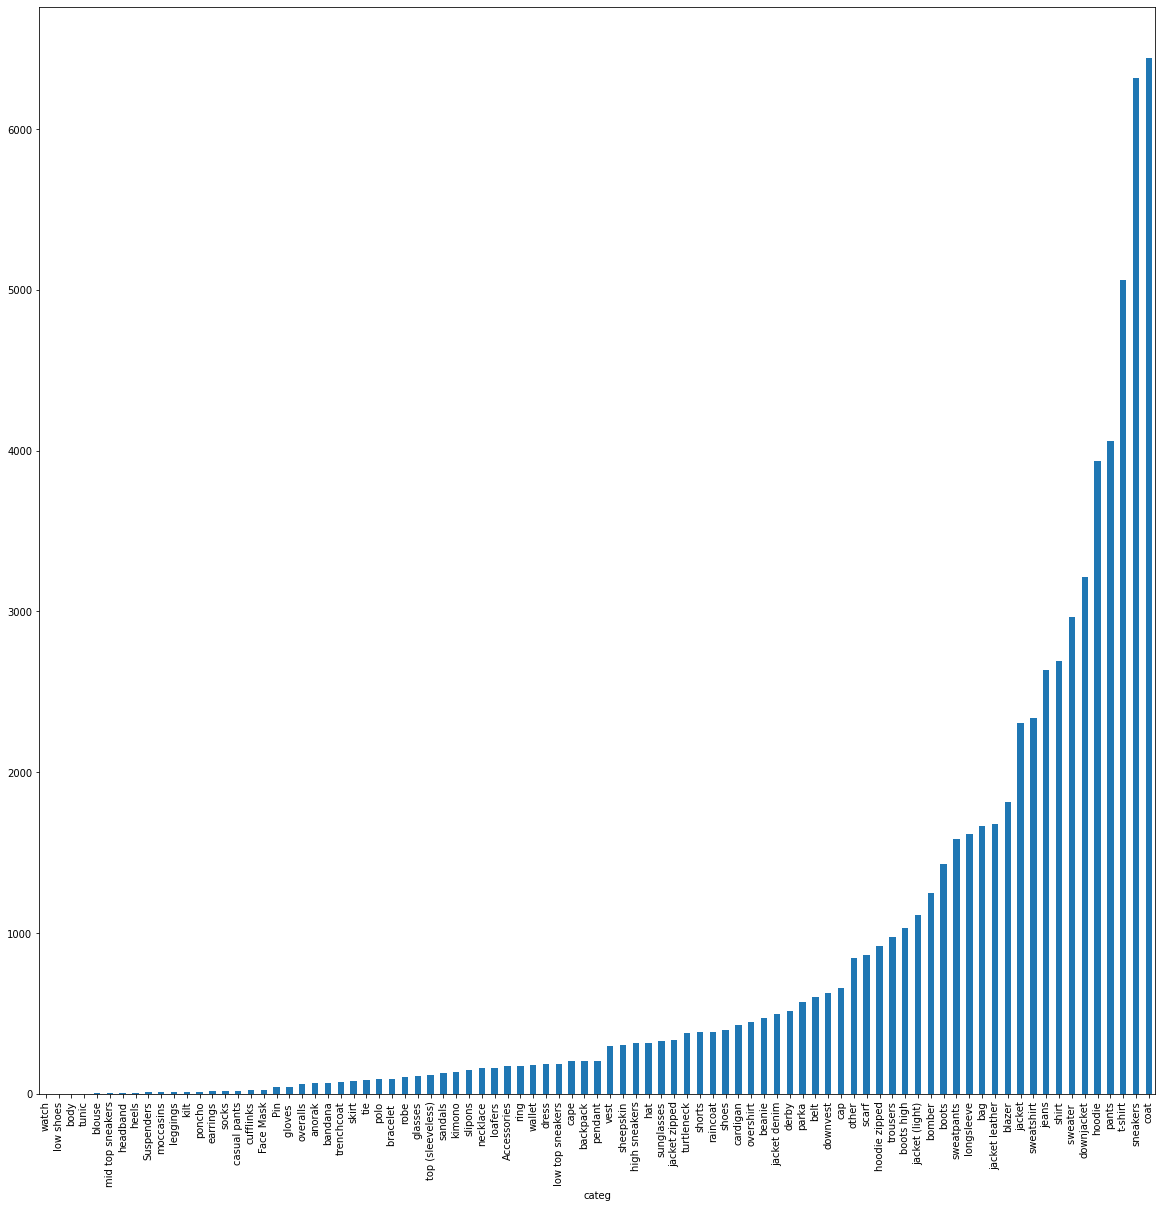

In [19]:
# добавляю всю информацию по каждой вещи
rating_full = rating.merge(vygruz, how = 'left', left_on='product_id', right_on='id_s')
# график с просмотрам по каждой категории товаров
rating_full.loc[:,['_id','categ']].groupby('categ')['_id'].sum().sort_values().plot(kind = 'bar', figsize = (20,20))

In [21]:
rating.merge(vygruz, how='left', left_on='product_id', 
             right_on='id_s').loc[:,['id','_id','days_in_stock','Цена шоурум','discount','categ','cond']].to_csv('rating_for_lm.csv')

In [33]:
cart.product_id.dropna().sort_values()

1116    2000000000046
1934    2000000000138
1184    2000000000169
627     2000000000220
1282    2000000000299
            ...      
1770    2000000118628
1253    2000000118710
522     2000000118741
1941    2000000118765
1002    2000000118772
Name: product_id, Length: 1952, dtype: int64

<AxesSubplot:xlabel='categ'>

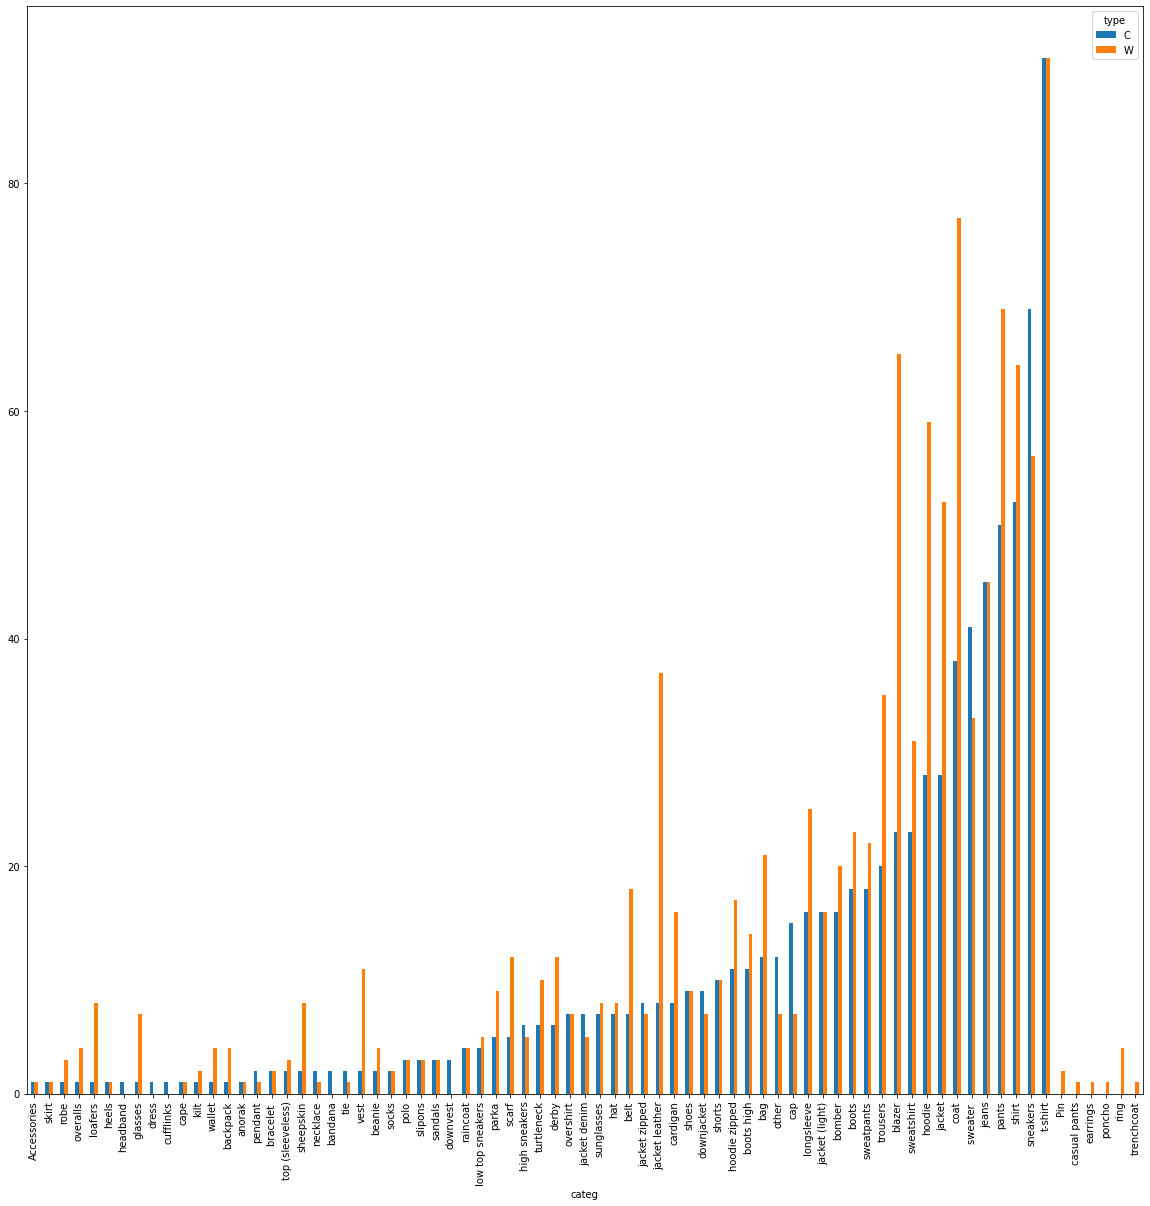

In [23]:
# теперь аналогично посмотрим на добавления в корзину/вишлисты
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False).astype(int)
cart = cart.dropna(subset = ['product_id'])
cart.loc[:,['product_id']] = cart.product_id.astype(int)

cart_full = cart.merge(vygruz.loc[:,['id','categ']], how='left', left_on='product_id', right_on='id')

cart_full_gb = cart_full.groupby(['type','categ'])['id'].count().reset_index()
cart_full_piv = cart_full_gb.sort_values(['type','id'], 
                                         ascending=[True, False]).pivot(columns = ['type'], 
                                                                        index = 'categ',
                                                                        values = 'id')
# сменить на барплоты!

cart_full_piv.sort_values('C').plot(kind = 'bar',subplots = False, layout = (2,1), figsize = (20,20), legend = True)


In [24]:
# достаю списки товаров из корзин/вишлистов/заказов каждого клиента
cart_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'W')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
wish_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'C')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
# засовываю в единый фрейм с учетом непересечений
cart_wish_user_prod = cart_user_prod.join(wish_user_prod, 
                                          how = 'outer', 
                                          on ='ym_client_id', 
                                          lsuffix = '_cart', 
                                          rsuffix = '_wish').drop_duplicates('ym_client_id').reset_index().drop(columns = 'index')
cart_wish_user_prod
# wish_user_prod

,ym_client_id,product_id_cart,product_id_wish
0,1586517765142996502,"[2000000079578, 2000000071244]","[2000000109862, 2000000098067]"
1,15945421401032860445,[2000000103075],NaN
2,1594795295110685242,"[2000000071398, 2000000087337, 2000000089102, ...",[2000000113975]
3,15958550101040682370,[2000000077543],"[2000000077482, 2000000039305, 2000000076768, ..."
4,1604905751812523282,"[2000000027265, 2000000107110, 2000000073316, ...",NaN
...,...,...,...
431,1639396664390528466,NaN,[2000000064703]
432,1639403209216883775,NaN,[2000000108698]
433,16394120081001631646,NaN,[2000000118215]
434,1639419123110521969,NaN,[2000000099613]


In [25]:
# создаю матрицу предпочтений по трем видам (пока что) оценок: просмотр товара, добавление в корзину/вишлист, добавление в заказ
products['ym_client_id'] = products['ym_client_id'].astype(str)
products = products.loc[products.product_id != 'NaN']

# делаю список со всеми возможными вещами, обрезать по наличию буду потом
all_items = np.concatenate([products.product_id.unique(),cart.product_id.astype(str).unique()])
product_id_cols = [str(i) for i in all_items]
product_id_cols.extend(['product_id_wish','product_id_cart','product_id', 'ym_client_id'])
product_id_cols.reverse()

user_product_heat = products.groupby('ym_client_id')['product_id'].apply(list).reset_index()
user_product_heat = user_product_heat.merge(cart_wish_user_prod, how ='outer', on = 'ym_client_id')
user_product_heat = user_product_heat.reindex(columns=product_id_cols, fill_value=0).set_index('ym_client_id')
user_product_heat = user_product_heat.loc[:,~user_product_heat.columns.duplicated()]
user_product_heat.fillna({'product_id':'', 'product_id_cart':'', 'product_id_wish':''}, inplace=True)

# заполняю матрицу предпочтений ранжированными значениями (!!запихнуть в функцию потом!!)
for i in range(user_product_heat.shape[0]):
    if type(user_product_heat.loc[:,'product_id'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 1
    if type(user_product_heat.loc[:,'product_id_cart'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id_cart'].iat[i]:
            
            user_product_heat[f'{product}'].iat[i] += 10
    if type(user_product_heat.loc[:,'product_id_wish'].iat[i])== list:
        for product in user_product_heat.loc[:,'product_id_wish'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 5

user_product_heat.drop(columns = ['product_id','product_id_cart','product_id_wish'], inplace = True)

#после этого, по сути, надо дропнуть вещи, которые уже архивные

user_product_heat

/var/folders/k_/q2nqvc5s4b9g7bf4ljty8wd00000gn/T/ipykernel_27430/3677423522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['ym_client_id'] = products['ym_client_id'].astype(str)


,2000000090177,2000000091587,2000000018416,2000000046327,2000000018447,2000000087047,2000000054926,2000000057118,2000000102214,2000000078571,...,200000007531,2000000082929,2000000099705,200000010117,2000000048,2000000002699,2000000102122,2000000099828,200000008451,2000000076294
ym_client_id,,,,,,,,,,,,,,,,,,,,,
1586517765142996502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586839436824718143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586861088574635654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586877094630823534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587480513689496288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639338939838372129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1639340042428973260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1639340203201076568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
vygruz.loc[:,['id_s']] = vygruz.id.astype(str)
combinations = {
    1:['categ'],
    2:['brand'],
    3:['categ','brand'],
    4:['brand','Группа категорий']
}



In [26]:
dict_combs = {}
for num, comb in combinations.items():
    cols = ['id_s']
    cols.extend(comb)
    brand_categ = user_product_heat.T.merge(vygruz.loc[:,cols], how='left',left_on = user_product_heat.T.index,right_on='id_s')
    stock = vygruz.loc[vygruz.reason == 'Приемка'].groupby(comb)['id_s'].count()
    
    dict_combs[num] = brand_categ.groupby(comb).sum()
    dict_combs[num] = dict_combs[num].join(stock)
    dict_combs[num] = dict_combs[num].loc[~((dict_combs[num].id_s.isna())|(dict_combs[num].id_s ==1))]
#     dict_combs[tuple(comb)].append(dict_combs[tuple(comb)].sum(numeric_only=True), ignore_index=True)


In [27]:
dict_combs[4]

1586517765142996502  \
brand                     Группа категорий                            
1017 ALYX 9SM             Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
99%Is                     Штаны и брюки                           0   
...                                                             ...   
Zegna Couture             Футболки и лонгсливы                    0   
Ziggy Chen                Джемперы и свитеры                      0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1586839436824718143  \
brand                     Группа категорий                            
1017 ALYX 9SM             Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
99%Is                     Штаны и брюки                           0   
...                                                             ...   
Zegna Couture             Футболки и лонгсливы                    0   
Ziggy Chen                Джемперы и свитеры                      0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1586861088574635654  \
brand                     Группа категорий                            
1017 ALYX 9SM             Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
99%Is                     Штаны и брюки                           0   
...                                                             ...   
Zegna Couture             Футболки и лонгсливы                    0   
Ziggy Chen                Джемперы и свитеры                      0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1586877094630823534  \
brand                     Группа категорий                            
1017 ALYX 9SM             Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
99%Is                     Штаны и брюки                           0   
...                                                             ...   
Zegna Couture             Футболки и лонгсливы                    0   
Ziggy Chen                Джемперы и свитеры                      0   
                          Футболки и лонгсливы                    0   
                          Штаны и брюки                           0   
ВЛАД ВЫСОЦКИЙ             Украшения и другое                      0   

                                                1587480513689496288  \
brand                     Группа категорий                            
1017 ALYX 9SM             Футболки и лонгсливы                    0   
10sei0otto                Джемперы и свитеры                      0   
11 By Boris Bidjan Saberi Футболки и лонгсливы                    0 

In [14]:
user_product_heat.iloc[0,3:].unique()

array([ 0,  5,  1,  2,  4, 11, 10])

In [15]:
dict_combs[('brand','categ')].append(dict_combs[('brand','categ')].sum(numeric_only=True), ignore_index=True)
dict_combs[('brand','categ')].loc[~((dict_combs[('brand','categ')].id_s.isna())|(dict_combs[('brand','categ')].id_s ==1))]
# dict_combs.keys()

KeyError: ('brand', 'categ')

In [19]:
dict_combs[3].append(dict_combs[3].sum(), ignore_index=True).T.sort_values(510).tail(60)

,0,1,2,3,4,5,6,7,8,9,...,501,502,503,504,505,506,507,508,509,510
163576228170635126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0
1631204559108529491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
1635708622259301920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
1630503134858055037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
1633564279975377400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
1633842921850964733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
1592929721329237660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
1633548670650787760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
162117904949439394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
1634101983816221654,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0


In [21]:
dict_combs[4].append(dict_combs[3].sum(), ignore_index=True).T.sort_values(493).tail(60)

,0,1,2,3,4,5,6,7,8,9,...,515,516,517,518,519,520,521,522,523,524
1634335297445640942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1634336040339353080,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0
1634336554492342974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1634336893385691054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163433703465155411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163433706433692872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634337463251867925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1634337562183495759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1634359813928386917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634357364287888513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
(dict_combs[4].drop(columns = ['id_s']).values > 0).mean()

0.0033556474303420274

In [23]:
(dict_combs[3].drop(columns = ['id_s']).values > 0).mean()

0.0028298722288293233

веса сделать параметром
три таблицы: 
1) по строчкам юзеры, по столбцам инфа по ним (даты визитов, число просмотров и тд)
2) то же самое по группам бренд-группа категорий (сколько товаров, сколько просмотров, когда)
3) сама матрица юзер-айтем
4) распределение клиент - устройство
5) сделать py файлы которые берут инфу из монги и обрабатывают ее в таблички 1)-3), эти файлы лежат в src 

In [29]:
# ready table one
# по строчкам юзеры, по столбцам инфа по ним (даты визитов, число просмотров и тд)
users_info = pd.DataFrame()
users_info.index = df_heat.ym_client_id.unique()

# всего переходов по страницам
users_info['views'] = df_heat.groupby('ym_client_id').agg({'_id':'count'})
#список просмотренных товаров
users_info['products'] = df_heat.loc[~df_heat.product_id.isin([0,'0',''])].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во просмотренных товаров (возможны повторные просмотры тех же товаров)
users_info['products_quan'] = df_heat.loc[~df_heat.product_id.isin([0,'0',''])].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']
#добавления в корзину
users_info['carts'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='C')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во добавлений в корзину
users_info['carts_quan'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='C')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']

#добавления в вишлист
users_info['wish'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='W')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во добавлений в вишлист
users_info['wish_quan'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='W')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']

users_info
# .loc[users_info.carts_quan>0].sort_values('views')




,views,products,products_quan,carts,carts_quan,wish,wish_quan
1634376464775853163,85,"[2000000084909, 200000008451, 2000000073705, 2...",53.0,NaN,NaN,NaN,NaN
16177636401065163291,162,"[2000000076294, 2000000051208, 2000000011011, ...",60.0,NaN,NaN,NaN,NaN
1630659159952734277,252,"[2000000107752, 2000000095073, 2000000104294, ...",41.0,NaN,NaN,NaN,NaN
1630833206792953159,413,"[2000000094601, 2000000108322, 2000000109251, ...",46.0,NaN,NaN,[2000000104775],1.0
163386231741398227,123,"[2000000082929, 200000007531, 2000000061689, 2...",35.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1639481559207804285,3,[2000000105154],1.0,NaN,NaN,NaN,NaN
1639481592883721269,6,NaN,NaN,NaN,NaN,NaN,NaN
1639481657167803254,1,[2000000115115],1.0,NaN,NaN,NaN,NaN
1639481667899261814,3,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
users_info.loc[users_info.wish_quan>0]

,views,products,products_quan,carts,carts_quan,wish,wish_quan
1630833206792953159,413,"[2000000094601, 2000000108322, 2000000109251, ...",46.0,NaN,NaN,[2000000104775],1.0
1634332198261008216,41,"[2000000101712, 2000000107707, 2000000107707, ...",17.0,NaN,NaN,"[2000000000299, 2000000064789, 2000000107707, ...",5.0
162721092532695845,304,"[2000000072418, 2000000072418, 2000000072425, ...",47.0,"[2000000066998, 2000000073354]",2.0,"[2000000039251, 2000000040868, 2000000038278, ...",16.0
1632300479943213942,289,"[2000000093383, 2000000018386, 2000000058443, ...",46.0,"[2000000090252, 2000000093383, 2000000095073, ...",5.0,"[2000000108728, 2000000038742, 2000000115351]",3.0
1633957867872449082,98,"[2000000090139, 2000000040059, 2000000107653, ...",30.0,[2000000105994],1.0,"[2000000049885, 2000000107653, 2000000090139]",3.0
...,...,...,...,...,...,...,...
1639244204412542966,69,"[2000000107196, 2000000107233, 2000000091587, ...",25.0,[2000000114620],1.0,"[2000000107233, 2000000060156, 2000000012544, ...",10.0
16204195481043631860,11,NaN,NaN,[2000000071077],1.0,"[2000000077987, 2000000072364, 2000000062327, ...",11.0
1639292206509479425,31,"[2000000107073, 2000000114842, 20000001166, 20...",12.0,NaN,NaN,[2000000116242],1.0
1639328016711046839,29,"[2000000101712, 200000007627, 2000000078328, 2...",14.0,NaN,NaN,[2000000104270],1.0


In [30]:
# ready table two 
# то же самое по группам бренд-группа категорий (сколько товаров, сколько просмотров, когда)
brand_categ_info = vygruz.loc[vygruz.reason =='Приемка'].groupby(['brand',
                                                                  'Группа категорий']).agg({'id':'count','id_s':list})
# .loc[vygruz.id_s.isin(df_heat.product_id.unique())] # для включения только тех групп, что просмотрены
brand_categ_info = brand_categ_info.loc[brand_categ_info.id > 0].sort_values('id', ascending = False)
# суммарные просмотры всех вещей из категории+бренда
brand_categ_info['total_views'] = brand_categ_info['id_s'].apply(lambda x: 
                                                                 df_heat.loc[df_heat.product_id.isin(x)]['_id'].count())
# среднее число просмотров одной вещи
brand_categ_info['mean_views'] = round(brand_categ_info['total_views'] / brand_categ_info['id'],2)
# список времен просмотров (можно сделать еще доп. столбец с относительной новизной)
brand_categ_info['view_times'] = brand_categ_info['id_s'].apply(lambda x: 
                                                                df_heat.loc[df_heat.product_id.isin(x)]['timestamp'].to_list())



brand_categ_info

id  \
brand              Группа категорий           
Haider Ackermann   Штаны и брюки         37   
Nike               Кроссовки и кеды      34   
Saint Michael      Свитшоты и худи       29   
Rick Owens Drkshdw Деним                 25   
Rick Owens         Штаны и брюки         23   
...                                      ..   
Isabel Benenato    Пальто и плащи         1   
                   Пиджаки и жилеты       1   
Issey Miyake       Пиджаки и жилеты       1   
                   Рубашки                1   
Рассвет            Футболки и лонгсливы   1   

                                                                                      id_s  \
brand              Группа категорий                                                          
Haider Ackermann   Штаны и брюки         [2000000018522, 2000000026091, 2000000031286, ...   
Nike               Кроссовки и кеды      [2000000028293, 2000000061771, 2000000066202, ...   
Saint Michael      Свитшоты и худи       [2000000085739, 2000000088556, 2000000088648, ...   
Rick Owens Drkshdw Деним                 [2000000077048, 2000000084145, 2000000084398, ...   
Rick Owens         Штаны и брюки         [2000000011011, 2000000055107, 2000000076676, ...   
...                                                                                    ...   
Isabel Benenato    Пальто и плащи                                          [2000000054094]   
                   Пиджаки и жилеты                                        [2000000102757]   
Issey Miyake       Пиджаки и жилеты                                        [2000000106731]   
                   Рубашки                                                 [2000000032375]   
Рассвет            Футболки и лонгсливы                                    [2000000118239]   

                                         total_views  mean_views  \
brand              Группа категорий                                
Haider Ackermann   Штаны и брюки                 458       12.38   
Nike               Кроссовки и кеды              828       24.35   
Saint Michael      Свитшоты и худи               125        4.31   
Rick Owens Drkshdw Деним                         139        5.56   
Rick Owens         Штаны и брюки                 190        8.26   
...                                              ...         ...   
Isabel Benenato    Пальто и плащи                 34       34.00   
                   Пиджаки и жилеты               10       10.00   
Issey Miyake       Пиджаки и жилеты               36       36.00   
                   Рубашки                        25       25.00   
Рассвет            Футболки и лонгсливы            0        0.00   

                                                                                view_times  
brand              Группа категорий                                                         
Haider Ackermann   Штаны и брюки         [2021-10-18 17:34:52, 2021-10-20 18:27:40, 202...  
Nike               Кроссовки и кеды      [2021-10-16 13:27:19, 2021-10-16 17:30:49, 202...  
Saint Michael      Свитшоты и худи       [2021-11-03 20:31:18, 2021-11-04 15:07:29, 202...  
Rick Owens Drkshdw Деним                 [2021-10-19 19:53:28, 2021-10-27 19:38:14, 202...  
Rick Owens         Штаны и брюки         [2021-10-16 18:22:08, 2021-10-16 20:00:52, 202...  
...                                                                                    ...  
Isabel Benenato    Пальто и плащи        [2021-10-17 23:02:49, 2021-10-20 23:27:50, 202...  
                   Пиджаки и жилеты      [2021-10-24 10:11:29, 2021-11-02 13:09:09, 202...  
Issey Miyake       Пиджаки и жилеты      [2021-10-17 15:33:40, 2021-10-17 22:51:29, 202...  
                   Рубашки               [2021-10-21 21:57:24, 2021-10-22 20:29:28, 202...  
Рассвет            Футболки и лонгсливы                                                 []  

[1369 rows x 5 columns]

<AxesSubplot:ylabel='Frequency'>

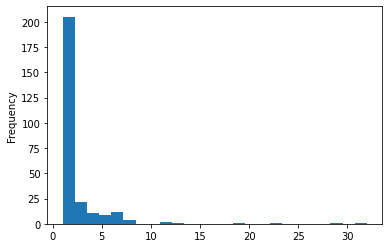

In [31]:
user_client_df = df_heat.loc[df_heat.user_id != 0].groupby(['user_id','ym_client_id']).count().reset_index()
user_client_df.drop(columns = ['_id','current_url','product_id','timestamp'], inplace=True)
user_client_df = user_client_df.join(user_client_df.groupby('user_id')['ym_client_id'].transform('count'), rsuffix = '_count')
# user_client = user_client_df.to_dict()
user_client_df.set_index('user_id', inplace=True)
user_client_df.reset_index().drop_duplicates('user_id')['ym_client_id_count'].plot(kind = 'hist', bins = 25)

In [32]:
user_client

NameError: name 'user_client' is not defined

In [131]:
vygruz.columns

Index(['Unnamed: 0', 'id', 'status', 'reason', 'cumdate', 'selldate',
       'Дата выплаты', 'comit', 'Условия договора на товар ', 'Наименование',
       'Артикул', 'categ', 'Группа категорий', 'brand', 'Размер по бирке',
       'Размер', 'Состав', 'Категория рентабельности', 'cond', 'Сезон', 'Год',
       'Цвет', 'Есть фото?', 'Кол-во фото', 'Цена Grailed', 'Цена шоурум',
       'actprice', 'Закупочная цена', 'Цена со скидкой', 'Сравнительная цена',
       'sellprice', 'Сумма выплаты', 'Стоимость доставки', 'Комиссия платежки',
       'Комиссия площадки', 'Восстановление товарного вида',
       'Ссылки на все размещения через ;', 'ссылка на яндекс диск',
       'Имя клиента ', 'Платежная система', 'Площадка продажи',
       'код транзакции пп', 'Ответственный ', 'Отправитель', 'Трек-номер',
       'Статус доставки', 'В аренду? да/нет', 'Сколько стоит в аренду',
       'сколько раз было в аренде', 'сколько денег за аренду всего ',
       'Рассчет к выплате', 'storage', 'days_in_stock'